In [1]:
# convolutional neural network 畳み込みニューラルネットワーク
# 用途：音声認識、自然言語処理、画像解析
# 膨大な特徴量を全結合するのではなく、畳み込み層、プーリング層を使って部分的に接続された層を接続していくことで
# 計算資源の節約に貢献する

# CNNアーキテクチャには様々な種類があるが2019 初頭現在はResNet が最優秀。
# 結局、畳み込み層、プーリング層、全結合層をどう組み合わせるのが優秀かという話


# お決まり設定
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from io import open

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
# 畳み込み層
# 受容野：人間が物体を見るとき、視野の限られた領域の視覚的刺激だけに反応している。
# つまり画像全体の特徴量ではなく、ごく一部の特徴量を畳み込むことで特徴量として作用させることができる

# 畳み込み層は領域の指定と二つの連続する受容野の距離、補正用のパディングで成り立っている
# 畳み込み層の設定には　幅、高さ、ストライド(連続する受容野の距離。こちらも高さと幅の指定が可能)が必要
# 0パディング　高さと幅が前の層と同じになるように入力の周囲に０を追加する。

# フィルタ
# 下記の縦線、横線のイメージで見れるようなフィルタをかけることでフィルタをかけられた部分以外を強調した　特徴量マップ　を作る
# パラメータの削減及び特定位置違いのパターン認識ができることもある

# 入力層、畳み込み層とも複数の特徴量マップを持つことができるため複数のフィルタを適用したり、任意の位置にある複数の特徴を検出できる
# 例：入力層にRGBの各色の特徴量マップを持ち、畳み込み層ではそれを受け取る各特徴量マップを持つ


# フィルタ機能を確認するためのグレースケール画像とRGB画像をプロットするための2つのユーティリティ関数
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [3]:
import tensorflow as tf

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

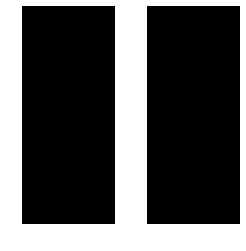

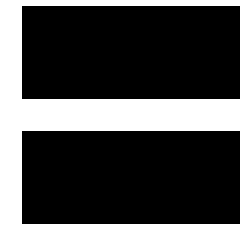

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()
# 縦線、横線のフィルタイメージ。白い部分が強調され、黒い部分は無視される

In [6]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

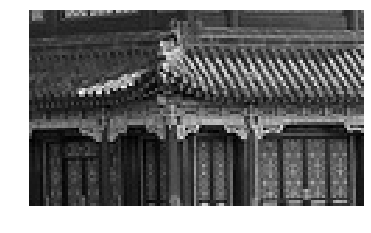

In [9]:
# オリジナル画像
plot_image(images[0, :, :, 0])
plt.savefig("china_original", tight_layout=False)
plt.show()

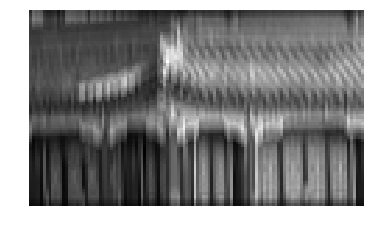

In [10]:
# 縦線のフィルタをかけた結果
plot_image(output[0, :, :, 0])
plt.savefig("china_vertical", tight_layout=False)
plt.show()
# 縦の白線部分が強調され、他がぼやける　ように見えないけどそうらしい

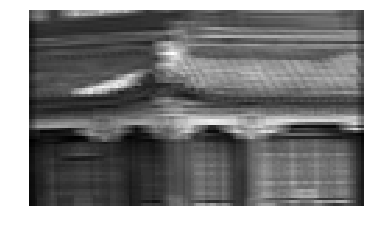

In [11]:
# 横線のフィルタをかけた結果
plot_image(output[0, :, :, 1])
plt.savefig("china_horizontal", tight_layout=False)
plt.show()
# 横の白線部分が強調され、他がぼやける　ように見えないけどね

In [ ]:
# 畳み込み層のtensorFlowでの実装
# tf.layers.conv2d()関数では最良のフィルタ設定と無作為初期化をしてくれるtf.layers.conv2d()関数がある
# tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],padding="SAME")
# filters:filterの数
# kernel_size:7x7の特徴量マップ
# strides:2x2 のストライド(この関数では縦横のストライドしか想定していない)
# padding 0の場合はパディング(0補完する)　Vpadding="VALID" の場合はパディングしない。その場合はみ出た領域が無視される

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


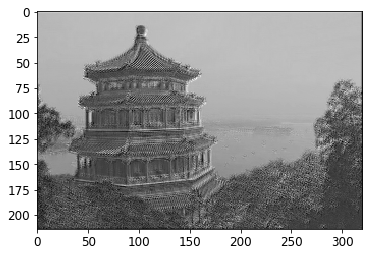

In [12]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape # (2, 427, 640, 3)

reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})
   
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

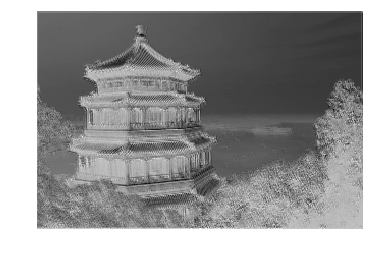

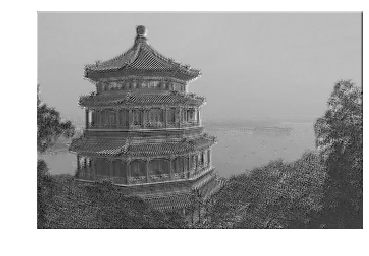

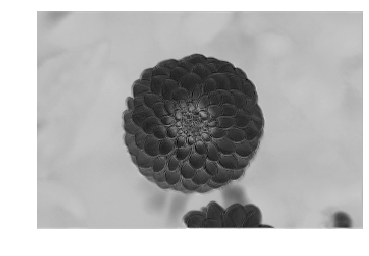

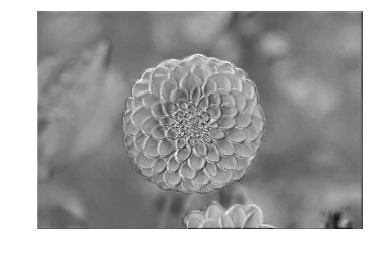

In [13]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

In [15]:
# プーリング層
# 重みのない畳み込み層。計算負荷の削減、メモリ使用量、パラメータの削減(過学習の緩和)を目的とする
# 入力画像のサブサンプリング(縮小)を行う層
# 最大値、平均値を使って、入力の集計を行う
# 最大値プーリング層：2x2のプーリングカーネルでストライド2、パディングなしだったとすると、各カーネルの入力の最大値のみが次の層にいく
# 平均値プーリング層：最大値プーリング層と同様。平均値のみが次の層に行き、各値は捨てられる

In [16]:
batch_size, height, width, channels = dataset.shape

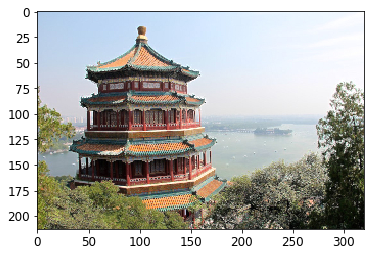

In [17]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

# 最大値プーリング層の作成
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")
# tf.nn.max_pool(入力、ksize=[batch_size(1固定), height, widgh, channels], strides=[1固定, 縦のストライド, 横のストライド, 1固定], padeing)

# 平均値プーリング層の作成
# mean_pool = tf.nn.avg_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

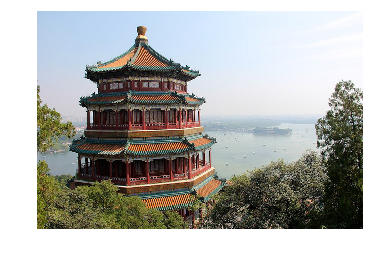

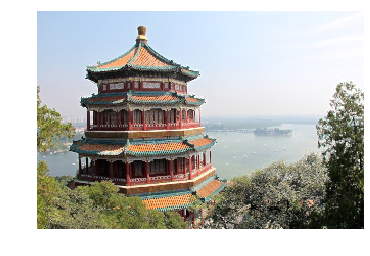

In [20]:
plot_color_image(dataset[0])
plt.savefig("china_original")
plt.show()
    
plot_color_image(output[0])
plt.savefig("china_max_pool")
plt.show()

In [26]:
# MNISTでのCNN実践
height = 28
width = 28
channels = 1
n_inputs = height * width

# 畳み込み層1の設定
conv1_fmaps = 32 # 整数、出力空間の次元数（すなわち畳み込み内のフィルタの数）。
conv1_ksize = 3 # 高さと幅を指定する整数または2つの整数のタプル/リスト。単一の整数にすることができる(この例では3x3)
conv1_stride = 1 # 高さと幅を指定する整数または2つの整数のタプル/リスト。単一の整数にすることができる(この例では1x1)
conv1_pad = "SAME" # パディングあり

# 畳み込み層2の設定
conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

# プーリング層の設定
pool3_fmaps = conv2_fmaps # 64

# 全結合層1(隠れ層)
n_fc1 = 64 # 出力の次元数
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    

# 畳み込み層1の作成
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

# 畳み込み層2の作成
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

# プーリング層の作成
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7]) # 出力の特徴量を調整している？ (?, 3136)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Using TensorFlow backend.


TypeError: __init__() got multiple values for argument 'filters'

In [22]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [23]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [24]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9775
1 Last batch accuracy: 0.98 Test accuracy: 0.9839
2 Last batch accuracy: 0.98 Test accuracy: 0.9802
3 Last batch accuracy: 0.98 Test accuracy: 0.9882
4 Last batch accuracy: 0.98 Test accuracy: 0.9878
5 Last batch accuracy: 1.0 Test accuracy: 0.989
6 Last batch accuracy: 1.0 Test accuracy: 0.9891
7 Last batch accuracy: 1.0 Test accuracy: 0.99
8 Last batch accuracy: 1.0 Test accuracy: 0.9877
9 Last batch accuracy: 1.0 Test accuracy: 0.9892


In [29]:
tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

<tf.Tensor 'Reshape:0' shape=(?, 3136) dtype=float32>